In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)

import copy, pickle, bentoml
from tqdm import tqdm 
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

import pandas_profiling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders import OneHotEncoder
from sklearn import metrics

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# turn off all Anacondas warnings)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#path = "/Users/salikh-khabibullin/Desktop/ML Lab/bitrate_prediction/"
path = "./"
data_train = pd.read_csv(path + "bitrate_train.csv")
data_test = pd.read_csv(path + "bitrate_test.csv")
print(data_train.shape, data_test.shape)

y_test = data_test["target"]

# I know, that it's not super optimal - I know about pd.concat() :)
da_train = copy.deepcopy(data_train)
da_test = copy.deepcopy(data_test)

(379021, 10) (228145, 10)


In [3]:
data_train.head()

fps_mean   fps_std  rtt_mean    rtt_std  dropped_frames_mean  \
0      24.4  0.516398      91.1   6.723921                  0.0   
1      28.6  2.065591      99.7  15.923777                  0.0   
2      30.0  0.000000      98.1  11.798776                  0.0   
3      30.3  0.948683      99.4  13.014522                  0.0   
4      29.9  0.316228     123.2  62.476307                  0.0   

   dropped_frames_std  dropped_frames_max  bitrate_mean  bitrate_std  target  
0                 0.0                 0.0         460.5     7.648529   616.0  
1                 0.0                 0.0         616.3   155.414893   565.0  
2                 0.0                 0.0         565.2     9.077445   573.0  
3                 0.0                 0.0         573.8    28.350191   585.0  
4                 0.0                 0.0         585.8    59.458295   555.0

In [4]:
data_test.head()

fps_mean   fps_std  rtt_mean   rtt_std  dropped_frames_mean  \
0      29.9  0.316228      55.0  0.942809                  0.0   
1      30.0  0.000000      55.0  0.942809                  0.0   
2      30.0  0.000000      56.0  3.299832                  0.0   
3      29.9  0.316228      58.4  4.599517                  0.0   
4      30.0  0.000000      54.7  1.251666                  0.0   

   dropped_frames_std  dropped_frames_max  bitrate_mean  bitrate_std  target  
0                 0.0                 0.0         682.8    36.468556   718.0  
1                 0.0                 0.0         718.0    43.609377   670.9  
2                 0.0                 0.0         670.9    24.378725   789.8  
3                 0.0                 0.0         789.8   238.545500   723.2  
4                 0.0                 0.0         723.2    40.846052   693.6

In [5]:
# because out target is bitrate
# so to have clear and honest model 
# I must remove bitrate_mean and bitrate_std

data_train.drop(["bitrate_mean", "bitrate_std"], axis = 1, inplace = True)

In [6]:
%%time

# Create the data profile report
profileReport = pandas_profiling.profile_report.ProfileReport(data_train, title = "Report_Regression")
profileReport.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 22.9 s, sys: 1.59 s, total: 24.5 s
Wall time: 26.3 s


In [7]:
profileReport

In [8]:
data_train.describe()

fps_mean        fps_std       rtt_mean        rtt_std  \
count  379021.000000  379021.000000  379021.000000  379021.000000   
mean       35.231127       1.725705      49.623858      12.763672   
std        10.975010       2.505942      94.781098     112.684460   
min        10.000000       0.000000       0.000000       0.000000   
25%        28.800000       0.316228      14.300000       0.699206   
50%        30.000000       0.942809      32.200000       1.433721   
75%        43.600000       2.233582      55.900000       4.948625   
max       125.800000     307.167273   12898.400000   40721.933293   

       dropped_frames_mean  dropped_frames_std  dropped_frames_max  \
count        379021.000000       379021.000000       379021.000000   
mean              0.180451            0.469548            1.450719   
std               1.732890            3.157866            9.670928   
min               0.000000            0.000000            0.000000   
25%               0.000000            0.000000            0.000000   
50%               0.000000            0.000000            0.000000   
75%               0.000000            0.000000            0.000000   
max             540.000000          202.385770          640.000000   

              target  
count  379021.000000  
mean     7525.396231  
std      6070.817736  
min         0.000000  
25%      2785.000000  
50%      6296.000000  
75%     10192.000000  
max     64913.000000

In [9]:
# Here I can also look for NaN columns)
data_train.isnull().sum().sum(), data_test.isnull().sum().sum()

(0, 0)

In [10]:
### I know about train, val and test parts of data.
### train part - to train our future model
### val - to validate and find giperparameters
### test - just to test our model
### In this task I didn't split in that way
### usually I do it like that:
### X_train, X_test, y_train, y_test = train_test_split(data_train, y, test_size = 0.2, random_state=42)
### X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 1/8, random_state=42)

### In CatBoost Model I DID it!!!

### First Model (with some features)

In [11]:
y_train = data_train["target"]

['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max']


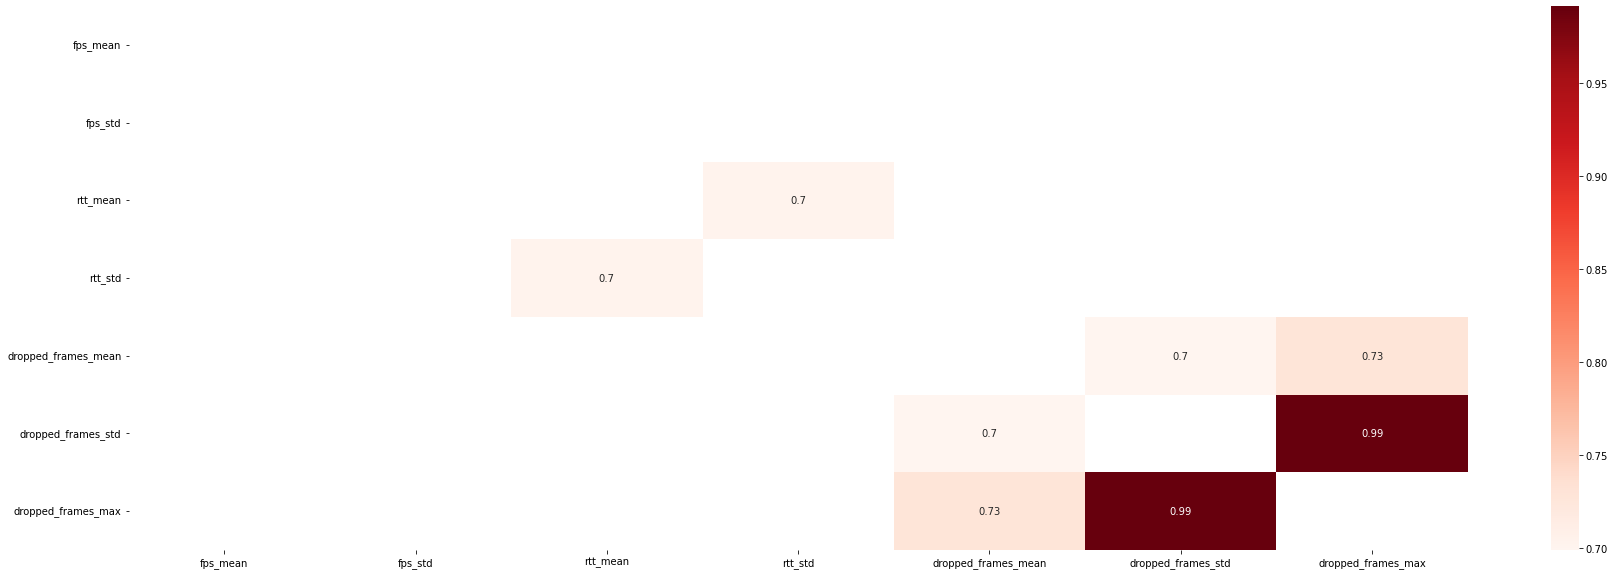

In [12]:
spi = list(data_train.columns)[:-1]
print(spi)

data_Corr = data_train[spi].corr(method = "pearson")
filteredDf = data_Corr[((data_Corr >= .5) | (data_Corr <= -.5)) & (data_Corr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [13]:
### I see high correlation between dropped_frames_mean and dropped_frames_max - so I want to drop dropped_frames_max

In [14]:
spisok = list(data_train.columns)[:-1]

# remove dropped_frames_std, dropped_frames_max
spisok.remove("dropped_frames_std")
spisok.remove("dropped_frames_max")
print(spisok)

data_train = data_train[spisok]
data_test = data_test[spisok]

['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean']


In [15]:
def calc_part(model, y_pred, lin_reg_flag = True):
    if lin_reg_flag == True:
        print(f"Model intercept : {model.intercept_}")
        print(f"Model coefficient : {model.coef_}")
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2_score = metrics.r2_score(y_test, y_pred)
    
    print('Mean Absolute Error: ', mae)
    print('Root Mean Squared Error: ', rmse)
    print('Coefficient of determination: ', r2_score, "\n")
    #return True

In [16]:
reg_1 = LinearRegression()
reg_1.fit(data_train[spisok], y_train)

y_pred_1 = reg_1.predict(data_test[spisok])
calc_part(reg_1, y_pred_1, lin_reg_flag = True)

scores = -cross_val_score(reg_1, data_train[spisok], y_train, cv = 5, scoring = "neg_mean_absolute_error")
print("mean of MAE : ", scores.mean())

scores = cross_val_score(reg_1, data_train[spisok], y_train, cv = 5, scoring = "r2")
print("mean of r2 : ", scores.mean())

Model intercept : 4053.58809948914
Model coefficient : [109.79758914  24.38907217 -10.22698199   4.21528327  83.82795578]
Mean Absolute Error:  4488.981340360033
Root Mean Squared Error:  5803.941985513858
Coefficient of determination:  0.05538122648334831 

mean of MAE :  4641.142124630271
mean of r2 :  0.045406325262793625


### Second model

In [17]:
def remove_outlies(data, feature):
    Q1 = data[feature].quantile(0.25) # 0.05
    Q3 = data[feature].quantile(0.75) # 0.95
    IQR = Q3 - Q1
    
    filter = (data[feature] >= Q1 - 1.5 * IQR) & (data[feature] <= Q3 + 1.5 *IQR)
    return data.loc[filter]

In [18]:
spisok.append("target")
print(spisok)

data_train = da_train[spisok]

['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'target']


In [19]:
data_train.head()

fps_mean   fps_std  rtt_mean    rtt_std  dropped_frames_mean  target
0      24.4  0.516398      91.1   6.723921                  0.0   616.0
1      28.6  2.065591      99.7  15.923777                  0.0   565.0
2      30.0  0.000000      98.1  11.798776                  0.0   573.0
3      30.3  0.948683      99.4  13.014522                  0.0   585.0
4      29.9  0.316228     123.2  62.476307                  0.0   555.0

In [20]:
# I know that it's not optimal for the Python-code)

df_1 = remove_outlies(data_train, "fps_mean")
df_2 = remove_outlies(data_train, "fps_std")
df_3 = remove_outlies(data_train, "rtt_mean")
df_4 = remove_outlies(data_train, "rtt_std")
df_5 = remove_outlies(data_train, "dropped_frames_mean")

new_train = pd.concat([df_1, df_2, df_3, df_4, df_5])
print(new_train.shape)

new_train = new_train.drop_duplicates()
print(new_train.shape)

new_y = new_train["target"]

spisok.remove("target")
new_train = new_train[spisok]

(1774070, 6)
(374396, 6)


In [21]:
reg_2 = LinearRegression()
reg_2.fit(new_train, new_y)

y_pred_2 = reg_2.predict(data_test[spisok])
calc_part(reg_2, y_pred_2, lin_reg_flag = True)

scores = -cross_val_score(reg_2, new_train, new_y, cv = 5, scoring = "neg_mean_absolute_error")
print("mean of MAE : ", scores.mean())

scores = cross_val_score(reg_1, data_train[spisok], y_train, cv = 5, scoring = "r2")
print("mean of r2 : ", scores.mean())

Model intercept : 3994.93602683948
Model coefficient : [114.29975445   5.44342086 -10.46015964   4.36839313  79.24875103]
Mean Absolute Error:  4499.847501968853
Root Mean Squared Error:  5808.064191022071
Coefficient of determination:  0.05403893342391741 

mean of MAE :  4632.708725072319
mean of r2 :  0.045406325262793625


In [22]:
spisok

['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean']

### Third model (remove outlies)

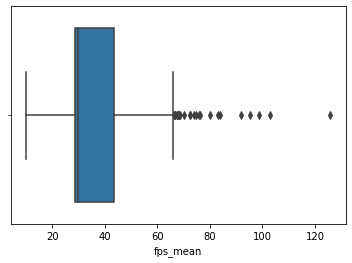

In [23]:
sns.boxplot(x = data_train["fps_mean"])

# remove some outlies
filter = (data_train["fps_mean"] <= 70)
data_train = data_train.loc[filter]

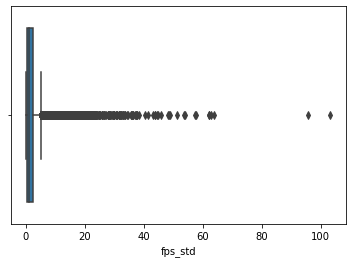

In [24]:
sns.boxplot(x = data_train["fps_std"]);

# remove some outlies
filter = (data_train["fps_std"] <= 40)
data_train = data_train.loc[filter]

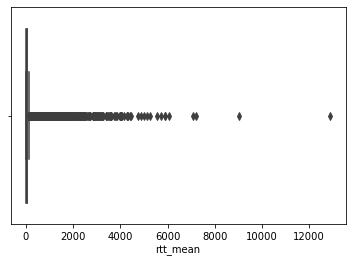

In [25]:
sns.boxplot(x = data_train["rtt_mean"]);

# remove some outlies
filter = (data_train["rtt_mean"] <= 4200)
data_train = data_train.loc[filter]

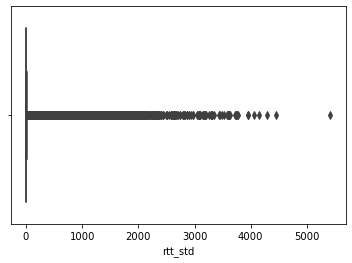

In [26]:
sns.boxplot(x = data_train["rtt_std"]);

# remove some outlies
filter = (data_train["rtt_std"] <= 2500)
data_train = data_train.loc[filter]

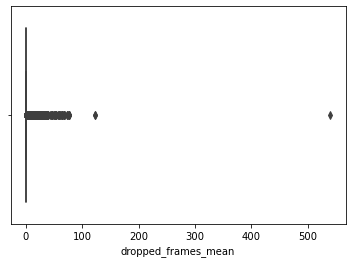

In [27]:
sns.boxplot(x = data_train["dropped_frames_mean"]);

# remove some outlies
filter = (data_train["dropped_frames_mean"] <= 90)
data_train = data_train.loc[filter]

In [28]:
data_train.describe()

fps_mean        fps_std       rtt_mean        rtt_std  \
count  378877.000000  378877.000000  378877.000000  378877.000000   
mean       35.230302       1.717616      48.797322      11.762186   
std        10.970280       2.369033      75.327806      73.865642   
min        10.000000       0.000000       0.000000       0.000000   
25%        28.800000       0.316228      14.300000       0.699206   
50%        30.000000       0.942809      32.200000       1.433721   
75%        43.600000       2.233582      55.800000       4.944132   
max        68.700000      38.388222    3988.000000    2483.472882   

       dropped_frames_mean         target  
count        378877.000000  378877.000000  
mean              0.177852    7526.033655  
std               1.464087    6071.017846  
min               0.000000       0.000000  
25%               0.000000    2786.000000  
50%               0.000000    6297.000000  
75%               0.000000   10192.000000  
max              77.000000   64913.000000

In [29]:
data_train.head()

fps_mean   fps_std  rtt_mean    rtt_std  dropped_frames_mean  target
0      24.4  0.516398      91.1   6.723921                  0.0   616.0
1      28.6  2.065591      99.7  15.923777                  0.0   565.0
2      30.0  0.000000      98.1  11.798776                  0.0   573.0
3      30.3  0.948683      99.4  13.014522                  0.0   585.0
4      29.9  0.316228     123.2  62.476307                  0.0   555.0

In [30]:
spisok

['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean']

In [31]:
new_y = data_train["target"]

data_train = data_train[spisok]

In [32]:
reg_3 = LinearRegression()
reg_3.fit(data_train, new_y)

y_pred_3 = reg_3.predict(data_test[spisok])
calc_part(reg_3, y_pred_3, lin_reg_flag = True)

scores = -cross_val_score(reg_3, data_train, new_y, cv = 5, scoring = "neg_mean_absolute_error")
print("mean of MAE : ", scores.mean())

scores = cross_val_score(reg_3, data_train, new_y, cv = 5, scoring = "r2")
print("mean of r2 : ", scores.mean())

Model intercept : 4180.36227464033
Model coefficient : [109.98137465  29.92935135 -13.48476175   4.82299104 117.39327379]
Mean Absolute Error:  4474.080824747453
Root Mean Squared Error:  5803.511900399778
Coefficient of determination:  0.0555212180343857 

mean of MAE :  4629.143623303459
mean of r2 :  0.05019688421829234


In [33]:
data_test.head()

fps_mean   fps_std  rtt_mean   rtt_std  dropped_frames_mean
0      29.9  0.316228      55.0  0.942809                  0.0
1      30.0  0.000000      55.0  0.942809                  0.0
2      30.0  0.000000      56.0  3.299832                  0.0
3      29.9  0.316228      58.4  4.599517                  0.0
4      30.0  0.000000      54.7  1.251666                  0.0

# Polunomenal Models

In [34]:
transformer = PolynomialFeatures(degree = 2, include_bias=False)

data_train_ = transformer.fit_transform(data_train)
data_test_ = transformer.transform(data_test)

reg_4 = LinearRegression().fit(data_train_, new_y)

y_pred_4 = reg_4.predict(data_test_)
calc_part(reg_4, y_pred_4, lin_reg_flag = True)

scores = -cross_val_score(reg_4, data_train_, new_y, cv = 5, scoring = "neg_mean_absolute_error")
print("mean of MAE : ", scores.mean())

scores = cross_val_score(reg_4, data_train, new_y, cv = 5, scoring = "r2")
print("mean of r2 : ", scores.mean())

Model intercept : -4725.02735238705
Model coefficient : [ 5.79720548e+02  4.18752857e+02 -7.33174454e+00 -1.17639771e+01
  5.53054025e+02 -5.45280991e+00 -8.36110546e+00 -3.17935872e-01
  2.66175207e-01 -5.43538240e+00 -9.77329904e+00  1.12324119e-01
  1.69370761e-01 -1.83904522e+00  3.84598653e-03  2.67313686e-03
  2.14891760e-01  2.59772981e-03 -3.32182467e-01 -5.53497855e+00]
Mean Absolute Error:  4429.656267116665
Root Mean Squared Error:  5848.697563242885
Coefficient of determination:  0.04075669615772992 

mean of MAE :  4578.320469493751
mean of r2 :  0.05019688421829234


In [35]:
transformer_2 = PolynomialFeatures(degree = 2, include_bias=False)

data_train_ = transformer_2.fit_transform(data_train)
data_test_ = transformer_2.transform(data_test)

reg_5 = LinearRegression().fit(data_train_, new_y)
y_pred_5 = reg_5.predict(data_test_)
calc_part(reg_5, y_pred_5, lin_reg_flag = True)

scores = -cross_val_score(reg_5, data_train_, new_y, cv = 5, scoring = "neg_mean_absolute_error")
print("mean of MAE : ", scores.mean())

scores = cross_val_score(reg_5, data_train, new_y, cv = 5, scoring = "r2")
print("mean of r2 : ", scores.mean())

Model intercept : -4725.02735238705
Model coefficient : [ 5.79720548e+02  4.18752857e+02 -7.33174454e+00 -1.17639771e+01
  5.53054025e+02 -5.45280991e+00 -8.36110546e+00 -3.17935872e-01
  2.66175207e-01 -5.43538240e+00 -9.77329904e+00  1.12324119e-01
  1.69370761e-01 -1.83904522e+00  3.84598653e-03  2.67313686e-03
  2.14891760e-01  2.59772981e-03 -3.32182467e-01 -5.53497855e+00]
Mean Absolute Error:  4429.656267116665
Root Mean Squared Error:  5848.697563242885
Coefficient of determination:  0.04075669615772992 

mean of MAE :  4578.320469493751
mean of r2 :  0.05019688421829234


### Lasso

In [36]:
data_train.head()

fps_mean   fps_std  rtt_mean    rtt_std  dropped_frames_mean
0      24.4  0.516398      91.1   6.723921                  0.0
1      28.6  2.065591      99.7  15.923777                  0.0
2      30.0  0.000000      98.1  11.798776                  0.0
3      30.3  0.948683      99.4  13.014522                  0.0
4      29.9  0.316228     123.2  62.476307                  0.0

In [37]:
alphas = [0.1, 0.5, 1, 2.5, 20, 50, 100]
for alpha in alphas:
    clf = Lasso(alpha = alpha).fit(data_train, new_y)
    y_pred = clf.predict(data_test)
    calc_part(clf, y_pred, lin_reg_flag = True)
    
    scores = -cross_val_score(clf, data_train, new_y, cv = 5, scoring = "neg_mean_absolute_error")
    print("mean of MAE : ", scores.mean(), "\n")
    
    scores = cross_val_score(clf, data_train, new_y, cv = 5, scoring = "r2")
    print("mean of r2 : ", scores.mean())

Model intercept : 4180.379450560746
Model coefficient : [109.98147038  29.91954421 -13.48470628   4.82307677 117.35155913]
Mean Absolute Error:  4474.08016862521
Root Mean Squared Error:  5803.511636020037
Coefficient of determination:  0.05552130408609168 

mean of MAE :  4629.142581557853 

mean of r2 :  0.05019713834231763
Model intercept : 4180.44815098125
Model coefficient : [109.98185322  29.88031593 -13.48448425   4.82341962 117.18470034]
Mean Absolute Error:  4474.077548992109
Root Mean Squared Error:  5803.510586574303
Coefficient of determination:  0.055521645665159935 

mean of MAE :  4629.138423756859 

mean of r2 :  0.05019815127741121
Model intercept : 4180.534016519305
Model coefficient : [109.98233156  29.83128144 -13.48420631   4.82384792 116.97612635]
Mean Absolute Error:  4474.074277957043
Root Mean Squared Error:  5803.509292904005
Coefficient of determination:  0.05552206673562743 

mean of MAE :  4629.133234940318 

mean of r2 :  0.05019940981879587
Model intercep

### Ridge

In [38]:
data_train.head()

fps_mean   fps_std  rtt_mean    rtt_std  dropped_frames_mean
0      24.4  0.516398      91.1   6.723921                  0.0
1      28.6  2.065591      99.7  15.923777                  0.0
2      30.0  0.000000      98.1  11.798776                  0.0
3      30.3  0.948683      99.4  13.014522                  0.0
4      29.9  0.316228     123.2  62.476307                  0.0

In [39]:
alphas = [0.1, 0.5, 1, 2.5, 20, 50, 100]
for alpha in alphas:
    clf = Ridge(alpha = alpha).fit(data_train, new_y)
    y_pred = clf.predict(data_test)
    calc_part(clf, y_pred, lin_reg_flag = True)
    
    scores = -cross_val_score(clf, data_train, new_y, cv = 5, scoring = "neg_mean_absolute_error")
    print("mean of MAE : ", scores.mean(), "\n")
    
    scores = cross_val_score(clf, data_train, new_y, cv = 5, scoring = "r2")
    print("mean of r2 : ", scores.mean(), "\n")

Model intercept : 4180.362282845633
Model coefficient : [109.98137437  29.92935362 -13.48476175   4.82299105 117.39325812]
Mean Absolute Error:  4474.080824558807
Root Mean Squared Error:  5803.511900253705
Coefficient of determination:  0.055521218081930335 

mean of MAE :  4629.143622528796 

mean of r2 :  0.050196884456379084 

Model intercept : 4180.362315668888
Model coefficient : [109.98137327  29.92936273 -13.48476172   4.82299107 117.39319542]
Mean Absolute Error:  4474.080823804184
Root Mean Squared Error:  5803.511899669415
Coefficient of determination:  0.0555212182721081 

mean of MAE :  4629.143619430144 

mean of r2 :  0.05019688540872569 

Model intercept : 4180.362356697953
Model coefficient : [109.98137189  29.92937412 -13.48476169   4.8229911  117.39311706]
Mean Absolute Error:  4474.080822860904
Root Mean Squared Error:  5803.511898939057
Coefficient of determination:  0.05552121850982894 

mean of MAE :  4629.143615556835 

mean of r2 :  0.05019688659915513 

Model 

### RandomForest

In [40]:
data_train.shape

(378877, 5)

In [41]:
%%time

# takes 3 minutes
rf_model = RandomForestRegressor().fit(data_train, new_y)
y_pred = rf_model.predict(data_test)
calc_part(rf_model, y_pred, lin_reg_flag = False)

# takes over 10 minutes
#scores = -cross_val_score(rf, data_train, new_y, cv = 3, scoring = "neg_mean_absolute_error")
#print(scores.mean(), "\n")

Mean Absolute Error:  4302.944106160361
Root Mean Squared Error:  5902.960688326574
Coefficient of determination:  0.02287476567544422 

CPU times: user 2min 36s, sys: 3.91 s, total: 2min 40s
Wall time: 2min 39s


### CatBoost

In [42]:
#X_train, X_test, y_train, y_test = train_test_split(data_train, new_y, test_size = 0.2, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(data_train, new_y, test_size = 0.1, random_state=42)

In [43]:
%%time

params = {'loss_function': "MAE", 
          'eval_metric': "MAE", 
          'verbose': 1000,
          'iterations': 3000, # 1000 
          'od_type': 'Iter', # "IncToDec",
          'l2_leaf_reg': 0.6,
          #'cat_features': cat_cols, # categorical features
          'random_seed': 1,}
grad_model_1 = CatBoostRegressor(**params)
grad_model_1.fit(X_tr, y_tr, 
                 eval_set = (X_val, y_val),    
                 use_best_model = True, 
                 plot = True);

y_pred = grad_model_1.predict(data_test)
calc_part(grad_model_1, y_pred, lin_reg_flag = False)

# takes 4 minutes
#scores = -cross_val_score(grad_model_1, data_train, new_y, cv = 3, scoring = "neg_mean_absolute_error")
#print(scores.mean(), "\n")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4621.5994823	test: 4661.8696883	best: 4661.8696883 (0)	total: 94.3ms	remaining: 4m 42s
1000:	learn: 3809.4379042	test: 3852.1564506	best: 3852.1564506 (1000)	total: 26.3s	remaining: 52.5s
2000:	learn: 3764.9712767	test: 3813.6928704	best: 3813.6866529 (1999)	total: 53s	remaining: 26.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 3800.593249
bestIteration = 2645

Shrink model to first 2646 iterations.
Mean Absolute Error:  3882.3400069029317
Root Mean Squared Error:  5481.832383532069
Coefficient of determination:  0.15732142658091408 

CPU times: user 2min 51s, sys: 16 s, total: 3min 7s
Wall time: 1min 11s


In [44]:
%%time

params = {'loss_function': "RMSE", 
          'eval_metric': "RMSE", 
          'verbose': 1000,
          'iterations': 3000, # 1000 
          'od_type': 'Iter', # "IncToDec",
          'l2_leaf_reg': 0.6,
          #'cat_features': cat_cols, # categorical features
          'random_seed': 1,}
grad_model_2 = CatBoostRegressor(**params)
grad_model_2.fit(X_tr, y_tr, 
                 eval_set = (X_val, y_val),    
                 use_best_model = True, 
                 plot = True);

y_pred = grad_model_2.predict(data_test)
calc_part(grad_model_2, y_pred, lin_reg_flag = False)

# takes 4 minutes
#scores = -cross_val_score(grad_model_2, data_train, new_y, cv = 3, scoring = "neg_mean_absolute_error")
#print(scores.mean(), "\n")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6039.1122705	test: 6110.8279816	best: 6110.8279816 (0)	total: 17ms	remaining: 51s
1000:	learn: 5176.1033363	test: 5249.6662262	best: 5249.6662262 (1000)	total: 16.1s	remaining: 32.2s
2000:	learn: 5073.0498078	test: 5168.1530364	best: 5168.1530364 (2000)	total: 32.7s	remaining: 16.3s
2999:	learn: 5015.4947019	test: 5129.0269841	best: 5129.0142371 (2998)	total: 49.3s	remaining: 0us

bestTest = 5129.014237
bestIteration = 2998

Shrink model to first 2999 iterations.
Mean Absolute Error:  4020.798612268543
Root Mean Squared Error:  5441.655021413053
Coefficient of determination:  0.16962845430028306 

CPU times: user 3min 40s, sys: 22.8 s, total: 4min 3s
Wall time: 50.1 s


In [45]:
%%time

params = { 'verbose': 1000,
          'iterations': 10000, # 1000 
          'od_type': 'Iter', # "IncToDec",
          'l2_leaf_reg': 0.6,
          #'cat_features': cat_cols, # categorical features
          'random_seed': 1,}
grad_model_3 = CatBoostRegressor(**params)
grad_model_3.fit(X_tr, y_tr, 
                 eval_set = (X_val, y_val),    
                 use_best_model = True, 
                 plot = True);

y_pred = grad_model_3.predict(data_test)
calc_part(grad_model_3, y_pred, lin_reg_flag = False)

# takes 4 minutes
#scores = -cross_val_score(grad_model_2, data_train, new_y, cv = 3, scoring = "neg_mean_absolute_error")
#print(scores.mean(), "\n")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6039.1122705	test: 6110.8279816	best: 6110.8279816 (0)	total: 26.1ms	remaining: 4m 21s
1000:	learn: 5176.1033363	test: 5249.6662262	best: 5249.6662262 (1000)	total: 16.3s	remaining: 2m 26s
2000:	learn: 5073.0498078	test: 5168.1530364	best: 5168.1530364 (2000)	total: 32.6s	remaining: 2m 10s
3000:	learn: 5015.4451871	test: 5129.0005243	best: 5129.0005243 (3000)	total: 49.1s	remaining: 1m 54s
4000:	learn: 4972.1319977	test: 5104.0016056	best: 5104.0016056 (4000)	total: 1m 6s	remaining: 1m 39s
5000:	learn: 4936.7694133	test: 5085.1462982	best: 5085.1462982 (5000)	total: 1m 23s	remaining: 1m 23s
6000:	learn: 4908.1895798	test: 5072.3010706	best: 5072.3010706 (6000)	total: 1m 41s	remaining: 1m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 5066.027884
bestIteration = 6591

Shrink model to first 6592 iterations.
Mean Absolute Error:  4029.114806542152
Root Mean Squared Error:  5476.346410174274
Coefficient of determination:  0.15900721289377828 

CPU times: use

In [ ]:
# Models like LinealRegression, LinealRegression(without outlies), Lasso, Ridge gives 
# thesame result in RMSE or in R2
# So the best model is CatboostModel (grad_model_2)

# I didn't create some powerful features because I could't combine them
# because they are measured in different dimensions

In [50]:
# I want to know the weight of features of CatBoostModel (grad_model_2)
weights = list(grad_model_2.feature_importances_)
names = list(grad_model_2.feature_names_)

model_dict = dict(zip(names, weights))
model_dict = sorted(model_dict.items(), key=lambda x: x[1])[::-1]

In [51]:
model_dict

[('rtt_mean', 39.89420127579558),
 ('fps_mean', 31.695246077627022),
 ('rtt_std', 14.847658348542845),
 ('fps_std', 11.807615419516834),
 ('dropped_frames_mean', 1.7552788785177198)]

In [ ]:
### I think you won't read to this place
### https://www.kaggle.com/salikh22